I have used the following methods.

* I used a model created with <b>ConvMixer </b> blocks [1,2],
* <b>gelu</b> activation function during the feature extraction stage,
* Used <b>tf.data</b> for input pipeline,
* 10 Kfold cross-validation,
* I split the full data into train (6563 images), validation (729 images) and test (1822 images),
* Applying ensemble method to 10-fold test predictions



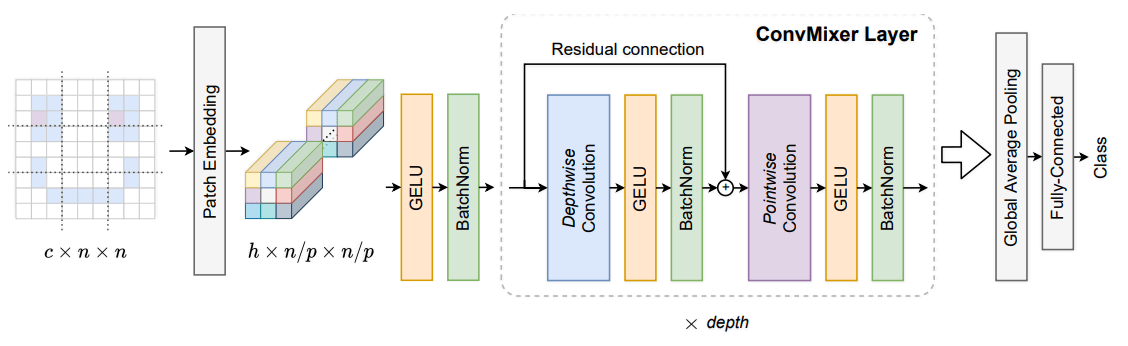


<i> ConvMixer Layer from the paper [1]</i>

## Test Set Predictions
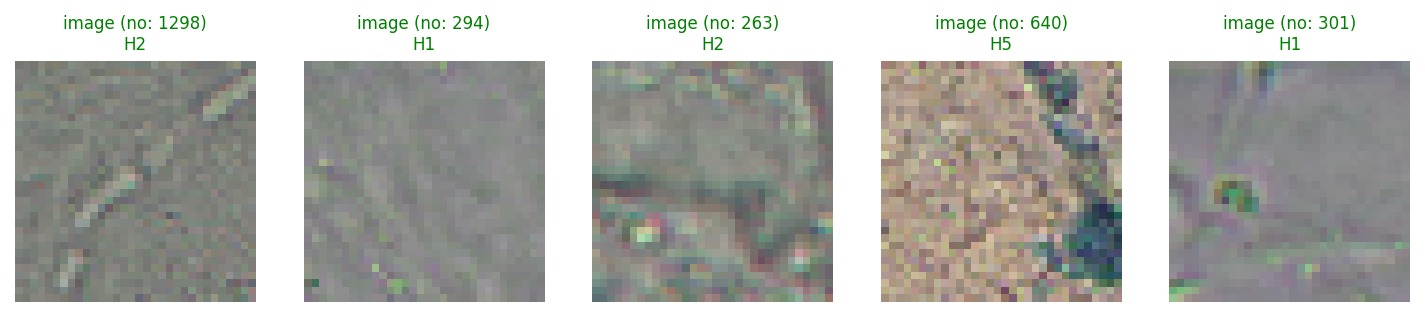


## References
1. Trockman, A., & Kolter, J. Z. (2022). Patches Are All You Need? (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2201.09792
2. https://keras.io/examples/vision/convmixer

In [1]:
# Importing dependencies

import os
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Input, Conv2D, GlobalAveragePooling2D, BatchNormalization, DepthwiseConv2D, Activation, Add
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer

IMG_SIZE = 32, 32
BATCH_SIZE = 128
SEED = 9
AUTO = tf.data.AUTOTUNE

# <span style="color:#e74c3c;"> Preprocessing </span>


In [2]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
import os

# Define the path to the zip file
zip_file_path = '/content/drive/My Drive/GDToT/archive.zip'

# Define the extraction path
extract_to_path = '/content/dataset'

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to_path)

print("Extraction completed. Files are in:", extract_to_path)

Mounted at /content/drive
Extraction completed. Files are in: /content/dataset


In [3]:
# Path to the main folder
main_folder_path = "/content/dataset"

# Lists to store image paths and microorganism names
image_paths = []
microorganism_names = []

# Traverse through subfolders
for subfolder_name in os.listdir(main_folder_path):
    subfolder_path = os.path.join(main_folder_path, subfolder_name)

    # Check if the element is a folder
    if os.path.isdir(subfolder_path):
        # Traverse through files in the subfolder
        for file_name in os.listdir(subfolder_path):
            image_path = os.path.join(subfolder_path, file_name)

            # Check if the element is an image file (adjust extensions according to your needs)
            if os.path.isfile(image_path) and file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(image_path)
                microorganism_names.append(subfolder_name)

# Create the dataframe
data = {'Image_Path': image_paths, 'Class': microorganism_names}
data_df = pd.DataFrame(data)

# Display the dataframe
print(data_df)
print(data_df.isna().sum())

                             Image_Path Class
0      /content/dataset/H6/H6_64a_6.jpg    H6
1      /content/dataset/H6/H6_59a_4.jpg    H6
2      /content/dataset/H6/H6_63a_1.jpg    H6
3      /content/dataset/H6/H6_37a_3.jpg    H6
4     /content/dataset/H6/H6_72a_11.jpg    H6
...                                 ...   ...
9109   /content/dataset/H2/H2_15a_2.jpg    H2
9110   /content/dataset/H2/H2_37c_5.jpg    H2
9111  /content/dataset/H2/H2_23b_13.jpg    H2
9112   /content/dataset/H2/H2_33b_6.jpg    H2
9113  /content/dataset/H2/H2_48a_15.jpg    H2

[9114 rows x 2 columns]
Image_Path    0
Class         0
dtype: int64


In [5]:
# Creating main dataframe contains image paths and their classes.

def create_images_list(path):
    full_path = []
    images = os.listdir(path)
    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


data_h1 = create_images_list('/content/dataset/H1')
data_h2 = create_images_list('/content/dataset/H2')
data_h3 = create_images_list('/content/dataset/H3')
data_h5 = create_images_list('/content/dataset/H5')
data_h6 = create_images_list('/content/dataset/H6')

# look-up table
fungus_classes = {0:'H1', 1 : 'H2', 2 : 'H3', 3 : 'H5', 4 : 'H6'}


data_df = pd.concat([  pd.DataFrame({"img" : np.array(data_h1) , "label": 0 }),
                        pd.DataFrame({"img" : np.array(data_h2) , "label": 1 }),
                        pd.DataFrame({"img" : np.array(data_h3) , "label": 2 }),
                        pd.DataFrame({"img" : np.array(data_h5) , "label": 3 }),
                        pd.DataFrame({"img" : np.array(data_h6) , "label": 4 })], ignore_index = True)

data_df = shuffle(data_df, random_state = SEED).reset_index(drop = True)

# <span style="color:#e74c3c;"> Creating </span> Train, Val, Test Datasets

In [6]:
# splitting into train_df (train and valid) and test_df
test_idx = data_df.shape[0] * 20 // 100  # 20 % for testing

train_df = data_df[test_idx:].reset_index(drop = True)
test_df = data_df[:test_idx].reset_index(drop = True)


print("train_df (train and val) shape -> ", train_df.shape[0])
print("test_df shape -> ", test_df.shape[0])

train_df (train and val) shape ->  7292
test_df shape ->  1822


# <span style="color:#e74c3c;"> Creating </span> Custom ConvMixer Layer

In [7]:
class ConvMixerBlock(Layer):
    def __init__(self, filters, kernel_size, patch_size, **kwargs):
        super(ConvMixerBlock, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.patch_size = patch_size

        self.deepwise = DepthwiseConv2D(kernel_size = kernel_size, padding = 'same')
        self.conv1 = Conv2D(filters, kernel_size = 1)
        self.act = Activation('gelu')
        self.bn1 = BatchNormalization()
        self.bn2 = BatchNormalization()

    def call(self, inputs):
        X = self.deepwise(inputs)
        X = self.act(X)
        X = self.bn1(X)
        X = Add()([X, inputs])
        X = self.conv1(X)
        X = self.act(X)
        X = self.bn2(X)

        return X


    def get_config(self):
        base_config = super().get_config()

        return {
            **base_config,
            "filters" : self.filters,
            "kernel_size": self.kernel_size,
            "patch_size": self.patch_size}

# <span style="color:#e74c3c;"> Model </span>


In [8]:
FEATURES = 256
inp = Input(shape = (*IMG_SIZE, 3))

X = Conv2D(FEATURES, 2, 2)(inp)
X = Activation('gelu')(X)
X = BatchNormalization()(X)

X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_1')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_2')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_3')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_4')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_5')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_6')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_7')(X)
X = ConvMixerBlock(FEATURES, 5, 2, name = 'CONVMIXER_8')(X)


X = GlobalAveragePooling2D()(X)
out = Dense(5, activation = 'softmax')(X)

model = Model(inputs = inp, outputs = out)
model.summary()

model.compile(optimizer = tf.keras.optimizers.AdamW(learning_rate = 0.0001,weight_decay = 0.0001),
              loss = tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics = ['acc',tf.keras.metrics.SparseTopKCategoricalAccuracy(k=2, name="top_2_acc", dtype=None) ] )

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 16, 16, 256)         │           3,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 16, 16, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16, 16, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_1 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_2 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_3 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_4 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_5 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_6 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_7 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ CONVMIXER_8 (ConvMixerBlock)         │ (None, 16, 16, 256)         │          74,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 601,605 (2.29 MB)

 Trainable params: 592,901 (2.26 MB)

 Non-trainable params: 8,704 (34.00 KB)

In [9]:
def compute_gradcam(model, img_array, class_idx=None, layer_name=None):
    # Set the layer for Grad-CAM visualization
    if layer_name is None:
        layer_name = [layer.name for layer in model.layers if isinstance(layer, tf.keras.layers.Conv2D)][-1]

    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()




# <span style="color:#e74c3c;"> Creating </span> tf.data Pipeline

In [10]:
# Reading -> Resizing -> Normalization
def img_preprocessing(image, label):
    img = tf.io.read_file(image)
    img = tf.io.decode_jpeg(img, channels = 3)
    img = tf.image.resize(img, size = (IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0

    return img, label


# Basic data augmentation
def augmentation(image, label):
    img = tf.image.random_flip_left_right(image)
    img = tf.image.random_flip_up_down(img)

    return image, label

In [11]:
# Creating test dataset loader and tf.dataset

test_loader = tf.data.Dataset.from_tensor_slices((test_df['img'], test_df['label']))
test_dataset = (test_loader
                .map(img_preprocessing, num_parallel_calls = AUTO)
                .batch(BATCH_SIZE)
                .prefetch(AUTO))

# <span style="color:#e74c3c;"> 10 Folds Training</span>

In [12]:
fold_hists = []
test_evals = []
test_preds = []

EPOCHS = 15
FOLDS = 10

kf = KFold(n_splits = FOLDS, shuffle = True, random_state = SEED)

for i, (train_index, val_index) in  enumerate(kf.split(train_df['img'], train_df['label'])):

    print('-'*80)
    print(str(i+1) + '.fold training')

    X_train_fold = train_df['img'][train_index]
    y_train_fold = train_df['label'][train_index]

    X_val_fold = train_df['img'][val_index]
    y_val_fold = train_df['label'][val_index]

    # Creating tf.pipeline
    train_loader = tf.data.Dataset.from_tensor_slices((X_train_fold, y_train_fold))
    train_dataset = (train_loader
                     .map(img_preprocessing, num_parallel_calls = AUTO)
                     .map(augmentation, num_parallel_calls = AUTO)
                     .batch(BATCH_SIZE)
                     .shuffle(BATCH_SIZE*5)
                     .prefetch(AUTO))

    validation_loader = tf.data.Dataset.from_tensor_slices((X_val_fold, y_val_fold))
    validation_dataset = (validation_loader
                          .map(img_preprocessing, num_parallel_calls = AUTO)
                          .batch(BATCH_SIZE)
                          .prefetch(AUTO))


    # Training
    hist = model.fit(train_dataset, epochs = EPOCHS, batch_size = BATCH_SIZE, validation_data = validation_dataset, verbose = 0)
    fold_hists.append(hist)

    # Test evaluation
    test_eval = model.evaluate(test_dataset)
    test_evals.append(test_eval)
    print('Test Loss: {0:.3f}'.format(test_eval[0]))
    print('Test Accuracy: {0:.3f} %'.format(test_eval[1]*100))
    print('Test Sparse Top 2 Accuracy: {0:.2f} %'.format(test_eval[2]*100))

    # Test set prediction
    test_take1 =  test_dataset.take(-1)
    test_take1_ = list(test_take1)
    pred = model.predict(test_take1)
    test_preds.append(pred)

--------------------------------------------------------------------------------
1.fold training
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 167ms/step - acc: 0.7104 - loss: 1.5997 - top_2_acc: 0.8907
Test Loss: 1.714
Test Accuracy: 69.210 %
Test Sparse Top 2 Accuracy: 88.80 %
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 192ms/step
--------------------------------------------------------------------------------
2.fold training
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - acc: 0.8291 - loss: 0.7088 - top_2_acc: 0.9398
Test Loss: 0.763
Test Accuracy: 81.833 %
Test Sparse Top 2 Accuracy: 93.52 %
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 120ms/step
--------------------------------------------------------------------------------
3.fold training
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step - acc: 0.8530 - loss: 0.5987 - top_2_acc: 0.9549
Test Loss: 0.682
Test Accuracy: 83.754 %
Test Sparse Top 2 Accuracy: 95.12 %
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step
--------------------------------------------------------------------------------
4.fold

# <span style="color:#e74c3c;"> Training </span> Results

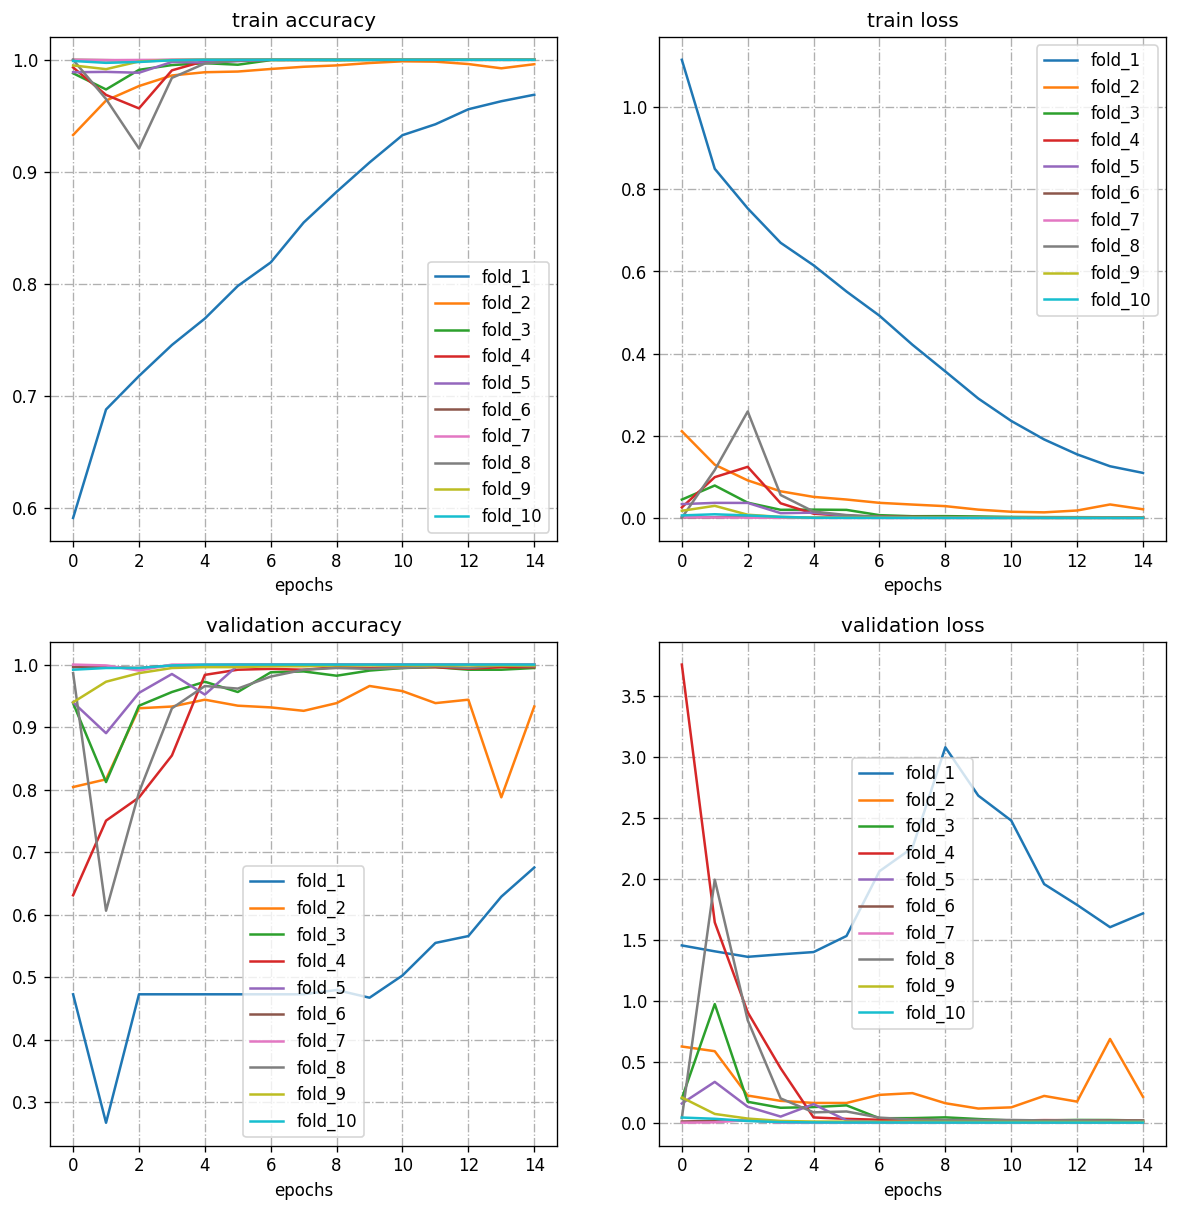

In [13]:
fig, axs = plt.subplots(2,2, figsize = (12,12) ,dpi = 120)

folds_name = []

axs[0][0].set_title('train accuracy')
axs[0][0].grid(linestyle = 'dashdot')
axs[0][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][0].plot(fold_hists[i].history['acc'])
    folds_name.append('fold_' + str(i + 1) )
axs[0][0].legend(folds_name, fontsize = 10)


axs[0][1].set_title('train loss')
axs[0][1].grid(linestyle = 'dashdot')
axs[0][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[0][1].plot(fold_hists[i].history['loss'])
axs[0][1].legend(folds_name, fontsize = 10)


axs[1][0].set_title('validation accuracy')
axs[1][0].grid(linestyle = 'dashdot')
axs[1][0].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][0].plot(fold_hists[i].history['val_acc'])
axs[1][0].legend(folds_name, fontsize = 10)


axs[1][1].set_title('validation loss')
axs[1][1].grid(linestyle = 'dashdot')
axs[1][1].set_xlabel('epochs', fontsize = 10)
for i in range(len(fold_hists)):
    axs[1][1].plot(fold_hists[i].history['val_loss'])
axs[1][1].legend(folds_name, fontsize = 10)


# <span style="color:#e74c3c;"> Ensemble Test </span> Predictions

In [14]:
# Calculating the mean of 10 folds predictions

preds = np.mean(test_preds, axis = 0)
last_pred = np.argmax(preds, axis = 1)

# <span style="color:#e74c3c;"> Test Classification </span> Report

In [15]:
clf = classification_report(test_df['label'] , last_pred, target_names = list(fungus_classes.values()))
print(clf)

              precision    recall  f1-score   support

          H1       0.86      0.91      0.89       898
          H2       0.78      0.72      0.75       450
          H3       0.81      0.75      0.78       156
          H5       0.91      0.88      0.90       170
          H6       0.93      0.93      0.93       148

    accuracy                           0.85      1822
   macro avg       0.86      0.84      0.85      1822
weighted avg       0.85      0.85      0.85      1822



# <span style="color:#e74c3c;"> Test Confusion </span> Matrix

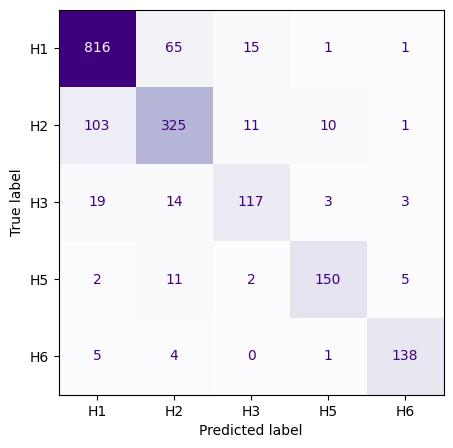

In [16]:
cm = confusion_matrix(test_df['label'] , last_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels = list(fungus_classes.values()))

fig, ax = plt.subplots(figsize=(5,5))
cmd.plot(ax=ax,  cmap = 'Purples', colorbar = False)

# <span style="color:#e74c3c;"> Layer Selection </span> for Grad-CAM

In [18]:
for layer in model.layers:
    print(layer.name, layer.output.shape)


input_layer (None, 32, 32, 3)
conv2d (None, 16, 16, 256)
activation (None, 16, 16, 256)
batch_normalization (None, 16, 16, 256)
CONVMIXER_1 (None, 16, 16, 256)
CONVMIXER_2 (None, 16, 16, 256)
CONVMIXER_3 (None, 16, 16, 256)
CONVMIXER_4 (None, 16, 16, 256)
CONVMIXER_5 (None, 16, 16, 256)
CONVMIXER_6 (None, 16, 16, 256)
CONVMIXER_7 (None, 16, 16, 256)
CONVMIXER_8 (None, 16, 16, 256)
global_average_pooling2d (None, 256)
dense (None, 5)


# <span style="color:#e74c3c;"> Grad-CAM </span>

In [40]:
# Grad-CAM Function
def compute_gradcam(model, img_array, class_idx=None, layer_name="CONVMIXER_8"):
    """
    Computes Grad-CAM for a given model and input image array.

    Args:
        model: The trained Keras model.
        img_array: Preprocessed image array (batch of size 1).
        class_idx: The class index for which Grad-CAM is computed.
        layer_name: The name of the convolutional layer to use for Grad-CAM.

    Returns:
        A Grad-CAM heatmap.
    """
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if class_idx is None:
            class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.reduce_max(heatmap) + tf.keras.backend.epsilon())
    return heatmap.numpy()


import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files  # Only needed for Colab. Remove if not using Colab.

# Function to preprocess the uploaded image
def preprocess_uploaded_image(image_path):
    """
    Preprocesses the uploaded image to match the input format for the model.
    Args:
        image_path (str): Path to the uploaded image.
    Returns:
        Preprocessed image array.
    """
    img = cv2.imread(image_path)  # Read the image
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    img = cv2.resize(img, IMG_SIZE)  # Resize to model's input size
    img = np.array(img, dtype=np.float32) / 255.0  # Normalize pixel values
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    return img

# Upload image function
def upload_and_visualize_gradcam(model, layer_name="CONVMIXER_8"):
    """
    Allows the user to upload an image and applies Grad-CAM visualization.
    Args:
        model: Trained Keras model.
        layer_name: Layer name to use for Grad-CAM.
    """
    # Upload the image
    uploaded = files.upload()  # Use an upload dialog
    for filename in uploaded.keys():
        print(f"Uploaded file: {filename}")

        # Preprocess the uploaded image
        img_array = preprocess_uploaded_image(filename)

        # Predict the class of the image
        predictions = model.predict(img_array)
        class_idx = np.argmax(predictions)

        # Compute Grad-CAM
        heatmap = compute_gradcam(model, img_array, class_idx=class_idx, layer_name=layer_name)

        # Resize and overlay heatmap
        heatmap_resized = cv2.resize(heatmap, (IMG_SIZE[1], IMG_SIZE[0]))
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        superimposed_img = cv2.addWeighted(np.uint8(img_array[0] * 255), 0.6, heatmap_colored, 0.4, 0)

        # Display the results
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 3, 1)
        plt.imshow(img_array[0])
        plt.title("Original Image", fontsize=12)
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(heatmap, cmap="jet")
        plt.title("Grad-CAM Heatmap", fontsize=12)
        plt.axis("off")

        real_label = filename[:2]

        plt.subplot(1, 3, 3)
        plt.imshow(superimposed_img)
        plt.title(f"Grad-CAM Overlay\n(Predicted: {fungus_classes[class_idx]}, True: {real_label})", fontsize=12)
        plt.axis("off")

        plt.show()



# <span style="color:#e74c3c;"> Grad-CAM </span> Result

Saving H3_1a_14.jpg to H3_1a_14.jpg
Uploaded file: H3_1a_14.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


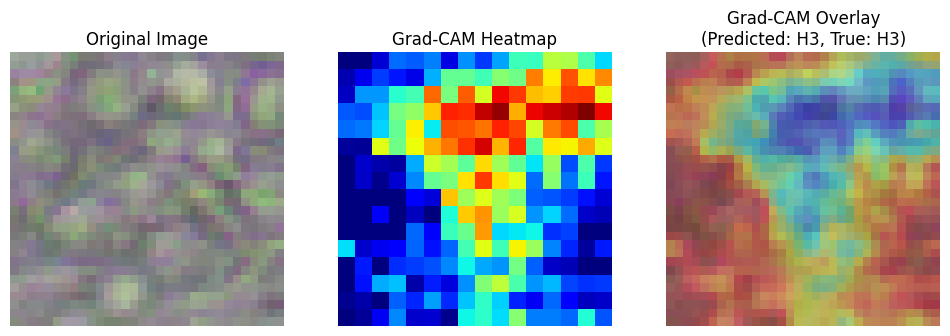

In [41]:
# Run the function
upload_and_visualize_gradcam(model)

# <span style="color:#e74c3c;"> Grad-CAM </span> Result

Saving H2_1a_8.jpg to H2_1a_8.jpg
Uploaded file: H2_1a_8.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


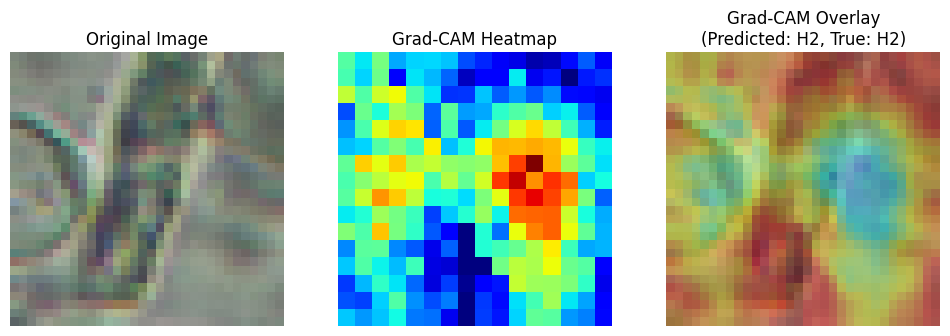

In [42]:
# Run the function
upload_and_visualize_gradcam(model)

# <span style="color:#e74c3c;"> Test </span> Predictions

In [38]:
# A function that creating 5 random images in the test set and predictions

# Red title -> a false prediction
# Green title -> a true prediction

test_take1 =  test_dataset.take(-1)
test_take1_ = list(test_take1)

def random_test_sample_with_prediction(SEED):
    idxs = np.random.default_rng(seed=SEED).permutation(len(last_pred))[:5]
    batch_idx = idxs // BATCH_SIZE
    image_idx = idxs-batch_idx * BATCH_SIZE
    idx = idxs

    fig, axs = plt.subplots(1,5, figsize = (12,12) ,dpi = 150)

    for i in range(5):
        img = test_take1_[batch_idx[i]][0][image_idx[i]]
        label = test_take1_[batch_idx[i]][1][image_idx[i]].numpy()


        if int(last_pred[idx[i]]) == label:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + fungus_classes[label], fontsize = 8, color = 'green')
        else:
            axs[i].imshow(img)
            axs[i].axis('off')
            axs[i].set_title('image (no: ' + str(idx[i])  + ')' + '\n' + fungus_classes[label], fontsize = 8, color = 'red')

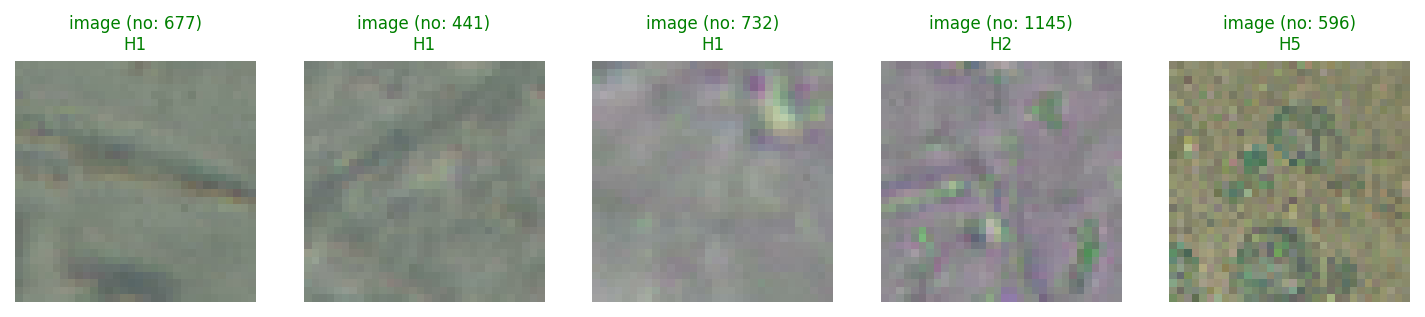

In [43]:
# Red title -> a false prediction
# Green title -> a true prediction

#random_test_sample_with_prediction(SEED = 5)
#random_test_sample_with_prediction(SEED = 10)
#random_test_sample_with_prediction(SEED = 4)
random_test_sample_with_prediction(SEED = 97)

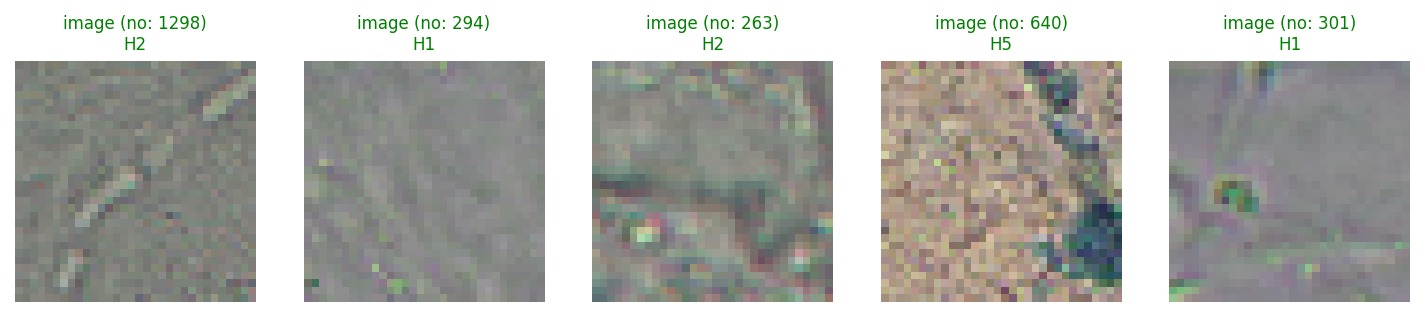

In [44]:
# Red title -> a false prediction
# Green title -> a true prediction

random_test_sample_with_prediction(SEED = 4)

# Project End